# Storing each 50ms row as a seperate spectrum
50 ms row = 1102 samples

13 rows = 650ms

In [1]:
import scipy
import scipy.signal
import numpy as np
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 4.0)

In [81]:
def restore(D, frame_size, hop_length, epochs=100, window='hann'):
    
    D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
    mag, _ = librosa.magphase(D)
    #mag = np.abs(D)
    
    phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
    x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)
    
    for i in range(epochs):
        _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=False,
                                                 window=window))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)
        
    return x_[hop_length:-hop_length]

In [3]:
def plot_spectrogram(S, sr, hop_length, y_axis='linear'):
    plt.figure(figsize=(25, 10))
    S = librosa.power_to_db(S)
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar()

### Loading Sounds

In [67]:
names = ['Ba.wav', 'fa.wav', 'Ga.wav', 'Ma.wav', 'Ra.wav', 'Bu.wav', 'Ru.wav', 'mu.wav', 'fu.wav', 'Gu.wav']
path = '/home/srg/Documents/MSU/EEG/data/sound_files/'
SR = 22050

Sounds = []
for name in names:
    Sounds.append(librosa.load(path + name, sr=SR)[0])

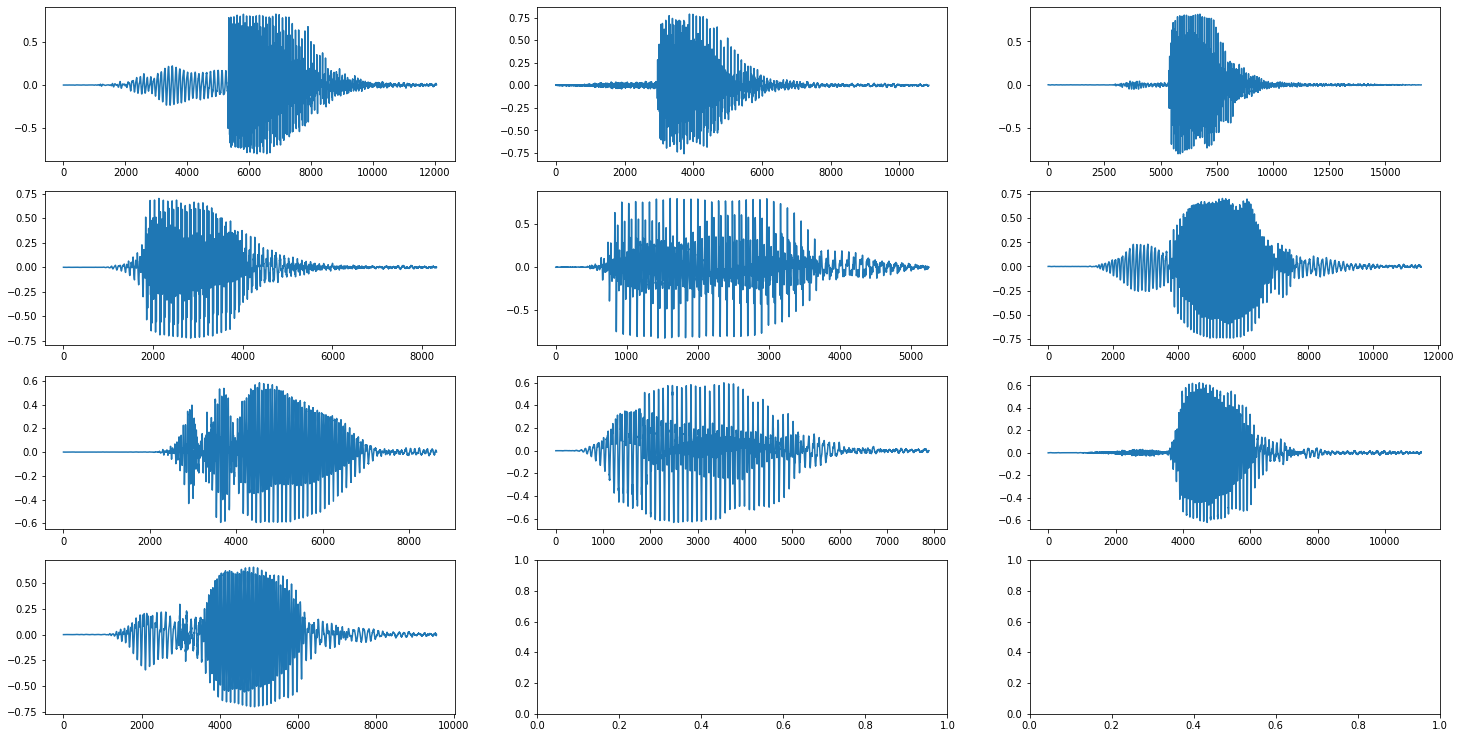

In [68]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(Sounds[3 * i + j])
        if 3 * i + j == 9:
            break

### Reshaping to 300 ms

In [69]:
Snd = np.empty((0, 6766))
Snd = np.append(Snd, Sounds[0][3000:9766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[1][1000:7766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[2][4000:10766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[3][:6766].reshape(1, -1), axis=0)
tmp = Sounds[4][:-1]
tmp = np.pad(tmp, ((6766 - tmp.shape[0]) // 2,
                           (6766 - tmp.shape[0]) // 2), 'constant', constant_values=(0, 0))
Snd = np.append(Snd, tmp.reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[5][2200:8966].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[6][-6766:].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[7][250:7016].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[8][2000:8766].reshape(1, -1), axis=0)
Snd = np.append(Snd, Sounds[9][1300:8066].reshape(1, -1), axis=0)

In [70]:
# Gu = 10 => 1st (since 10 % 10 = 0)
Snd = np.concatenate((Snd[-1].reshape(1, -1), Snd[:-1, :]))
Snd.shape

(10, 6766)

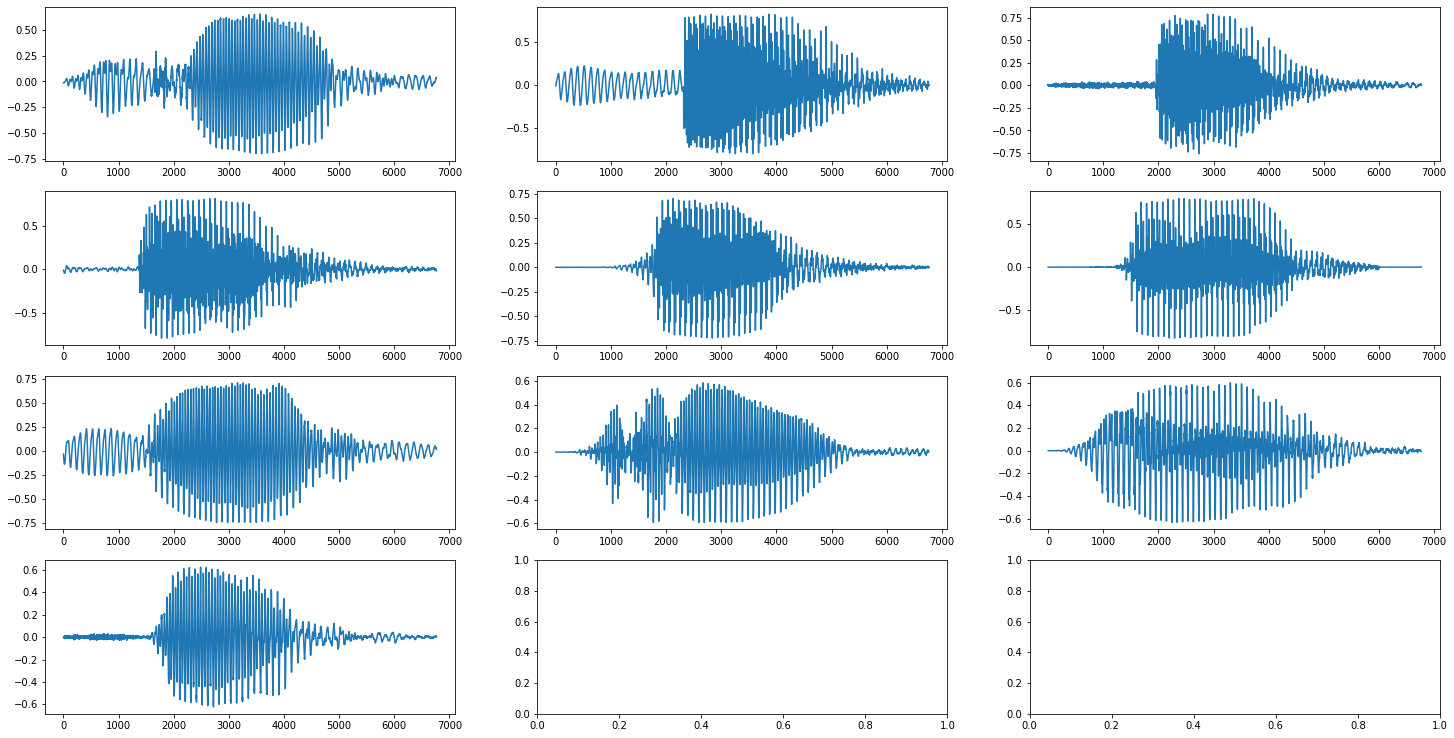

In [71]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i, snd in enumerate(Snd):
    axes[i // 3][i % 3].plot(snd)

In [51]:
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, np.squeeze(Snd.reshape(-1, 1)))

# Computing spectrums

In [72]:
FRAME_SIZE = 512
SR = 22050
HOP_LENGTH = 118

    6 rows = 4642 samples
    8 rows = 6058 samples
    9 rows = 6766 samples

##### Contiguous slice

In [73]:
sounds = np.squeeze(Snd.reshape(-1, 1))
sounds.shape

(67660,)

In [74]:
# Whole sound -> spectrum

spec = np.abs(librosa.stft(sounds, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
spec.shape

(257, 570)

##### Single syllable -> spectrum

In [53]:
# with some space in-between

sounds = np.empty((0, 6766))
for sound in Snd.reshape(10, -1):
    sounds = np.append(sounds, np.zeros((5, 6766)))
    sounds = np.append(sounds, sound.reshape(1, -1))

In [75]:
spec = np.empty((257, 0))
for snd in Snd.reshape(10, -1):
    x = np.abs(librosa.stft(snd, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
    spec = np.append(spec, x, axis=1)
spec.shape

(257, 540)

In [27]:
x_ = restore(spec, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/from_spec.wav', SR, x_)

### A, B matrices

In [43]:
LEARNING_SAMPLES = 26

In [46]:
A = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/bash.csv', delimiter=',', ndmin=2)
label = A[:, 0]
A = A[:, 1:]
A.shape

(25586, 1176)

In [47]:
all_indices = np.arange(len(label))[label > 10]
odd_indices = set(all_indices - 1).intersection(all_indices)
indices = set(all_indices) - odd_indices
indices = np.array(sorted(list(indices)))
# [print(i) for i in zip(indices, label[indices])]

In [4]:
inds = indices + 3
inds = np.array(sorted(list(set(inds).union(*[set(inds + j) for j in range(1, 9)]))))
data = A[inds]

In [5]:
data.shape

(1998, 1176)

In [48]:
# 13 in between

def get_nearest(label, ind):
    while label[ind] != 0:
        ind += 1
    return ind - 1

restricted_mode = False 
rest_num = 1
rest_arr = np.zeros(10)
indices1 = np.empty(0)
indices2 = np.empty(0)
hops = 18 # zeroes
flag = 0 # in block 
count = 0

for i, val in enumerate(label):
    if val == 0:
        if flag:
            count += 1
            continue
        else:
            continue
    
    if val > 10:
        if restricted_mode & (rest_arr[int(val) % 10] == rest_num):
            continue
        count = 0
        flag = 1
        last_ind = i
    else:
        if count != hops:
            count = 0
            continue
        else: 
            count = 0
            flag = 0
            if restricted_mode:
                rest_arr[int(val) % 10] += 1
            indices1 = np.append(indices1, last_ind)
            indices2 = np.append(indices2, get_nearest(label, i))
            
#indices1 = np.array(sorted(list(set(indices1).union(*[set(indices1 + j) for j in range(1, 13)]))))
#indices2 = np.array(sorted(list(set(indices2).union(*[set(indices2 + j) for j in range(1, 13)]))))
#inds = np.array(sorted(list(set(indices1).union(indices2)))).astype(int)
inds = indices1.astype(int) + 3
inds = np.array(sorted(list(set(inds).union(*[set(inds + j) for j in range(1, 9)]))))
label[inds].shape
#[print(i) for i in zip(indices1, indices2)]

(990,)

In [49]:
label[(inds - 3)[::9]]

array([18., 13., 13., 13., 14., 12., 20., 19., 16., 18., 19., 17., 15.,
       11., 13., 11., 11., 15., 14., 13., 16., 17., 17., 19., 13., 12.,
       11., 20., 12., 16., 20., 18., 16., 12., 11., 11., 16., 17., 17.,
       16., 19., 20., 15., 17., 13., 20., 18., 17., 19., 16., 15., 13.,
       20., 17., 15., 14., 14., 20., 11., 18., 16., 19., 14., 17., 20.,
       11., 14., 20., 16., 14., 20., 15., 15., 18., 13., 16., 12., 17.,
       13., 16., 18., 14., 20., 12., 18., 13., 14., 14., 17., 13., 19.,
       20., 12., 20., 16., 11., 11., 18., 17., 17., 13., 15., 14., 14.,
       16., 12., 16., 15., 18., 12.])

#### Indices for dev set

In [50]:
label_inds = (inds - 3)[::9]

In [60]:
dev_indices = np.empty(0)
for i in range(11, 20 + 1):
    l = label_inds[label[label_inds] == i]
    np.random.shuffle(l)
    dev_indices = np.append(dev_indices, l[:1] + 3)
dev_indices = np.array(sorted(list(set(dev_indices).union(*[set(dev_indices + j) for j in range(1, 9)])))).astype(int)

In [61]:
dev_indices.shape

(90,)

In [85]:
label[(dev_indices - 3)[::9]]

array([16., 15., 17., 11., 19., 18., 14., 20., 12., 13.])

In [64]:
new_inds = set(inds) - set(dev_indices)
new_inds = np.array(sorted(list(new_inds)))

In [65]:
new_inds.shape

(900,)

In [40]:
# Test on 20

indices20 = indices[label[indices] == 20]
indices20 += 3 # or + 4
indices20 = np.array(sorted(list(set(indices20).union(*[set(indices20 + j) for j in range(1, 9)]))))
indices20.shape

(234,)

##### A

In [152]:
data = np.empty((0, 36))

In [178]:
data = np.append(data, A[indices11[:9]], axis=0)
data.shape

(54, 36)

Or

In [66]:
#data = A[indices20[:9*LEARNING_SAMPLES]]
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/A_train.csv", A[new_inds], delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/A_dev.csv", A[dev_indices], delimiter=",")

##### B

In [78]:
B = np.empty((0, 257*6))
localspecs = spec.T.reshape(10, 54, 257).reshape(10, 54*257)

for l in label[(dev_indices - 3)[::9]].astype(int):
    #B = np.append(B, np.zeros((1, 257*6)), axis=0)
    B = np.append(B, localspecs[l % 10].reshape(54, 257).reshape(9, 6*257), axis=0)
    #B = np.append(B, np.zeros((1, 257*6)), axis=0)

B.shape

(90, 1542)

In [79]:
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/B_dev.csv", B, delimiter=",")

In [86]:
# Check 

Bt = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/B_dev.csv', delimiter=',', ndmin=2)
Bt = Bt.reshape(-1, 6, 257).reshape(-1, 257).T
x_ = restore(Bt, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x_)

In [121]:
#np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/A.csv", A[indices11[:9*LEARNING_SAMPLES]], delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/A.csv", data, delimiter=",")
#np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv",
#           np.linalg.pinv(A[indices11[:9*LEARNING_SAMPLES]]), delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv",
           np.linalg.pinv(data), delimiter=",")
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/B.csv", B, delimiter=",")

# Training X

In [3]:
Aplus = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/Ainv.csv', delimiter=',', ndmin=2)
B = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/B.csv', delimiter=',', ndmin=2)
X = np.dot(Aplus, B)
X.shape

(1176, 1542)

In [5]:
Atest = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/bash.csv', delimiter=',', ndmin=2)[:, 1:]
Res = np.dot(Atest, X)

In [131]:
Res = Res.reshape(-1, 6, 257).reshape(-1, 257).T

In [132]:
x_ = restore(Res, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x_)

In [200]:
Signal = np.empty((0, 1102))
for spec in Res:
    x_ = restore(spec.reshape(174, 10), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/130rows.wav', SR, x)

##### Studying spectrum

In [129]:
Specs = np.empty((0, 552))
syl = Snd[0]
for row in syl:
    x = librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False, window=np.ones(1102))
    Specs = np.append(Specs, x.T, axis=0) # x is (552, 1)

_, phase = librosa.magphase(Specs)
mag = np.abs(Specs)
Specs.shape

(13, 552)

In [130]:
# plot_spectrogram(np.abs(Specs.T), sr=SR, hop_length=FRAME_SIZE, y_axis='log')

In [131]:
Signal = np.empty((0, 1102))
for i, spec in enumerate(mag):
    x_ = librosa.istft(spec.reshape(552, 1) * phase[i].reshape(552, 1), hop_length=HOP_LENGTH, center=False,
                       window=np.ones(1102))
    #Signal = np.append(Signal, x_[1:-1].reshape(1, -1), axis=0)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, np.squeeze(Signal.reshape(-1, 1)))

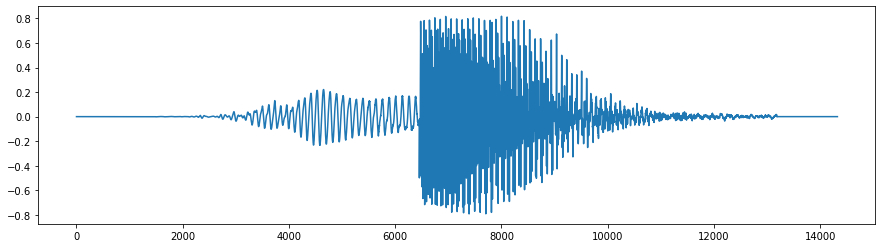

In [132]:
y = np.squeeze(Signal.reshape(-1, 1))
plt.plot(y)

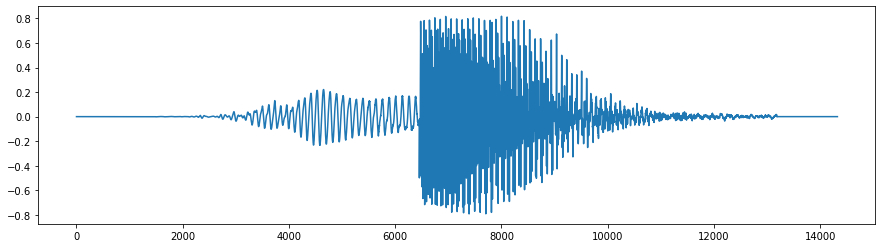

In [133]:
x = np.squeeze(Snd[0].reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)
plt.plot(x)

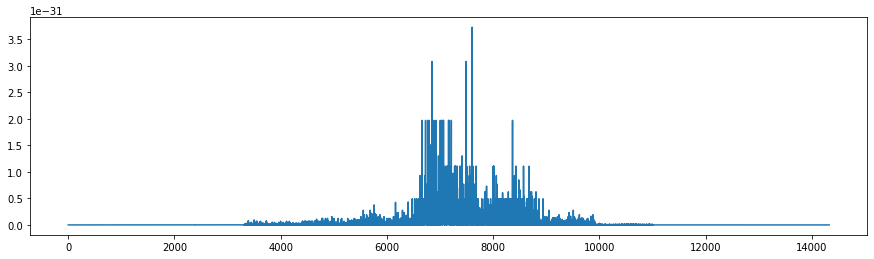

In [134]:
plt.plot((x - y) ** 2)

In [135]:
np.arange(len(x))[((x - y) ** 2) > 0.000001][:500]

array([], dtype=int64)

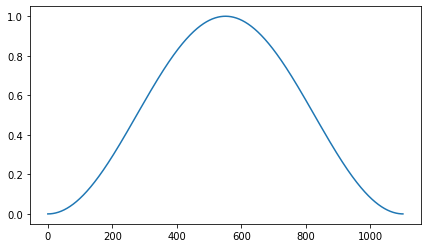

In [83]:
plt.plot(scipy.signal.hann(1102, sym=False))

### Back to sound

In [182]:
Signal = np.empty((0, 1102))
for i, spec in enumerate(Specs.reshape(130, 552)):
    x_ = restore(spec.reshape(552, 1), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10, window=np.ones(1102))
    #x_ = librosa.istft(spec.reshape(552, 1) * phase[i % 13].reshape(552, 1), hop_length=HOP_LENGTH, center=False, 
    #                  window=np.ones(1102))
    d = max(np.max(x_), 1)
    Signal = np.append(Signal, (x_ / d).reshape(1, -1), axis=0)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, np.squeeze(Signal.reshape(-1, 1)))

#### Plotting restored sounds

In [183]:
cutSignal = Signal.reshape(10, -1)
cutSignal = cutSignal * (cutSignal < 1) * (cutSignal > -1)

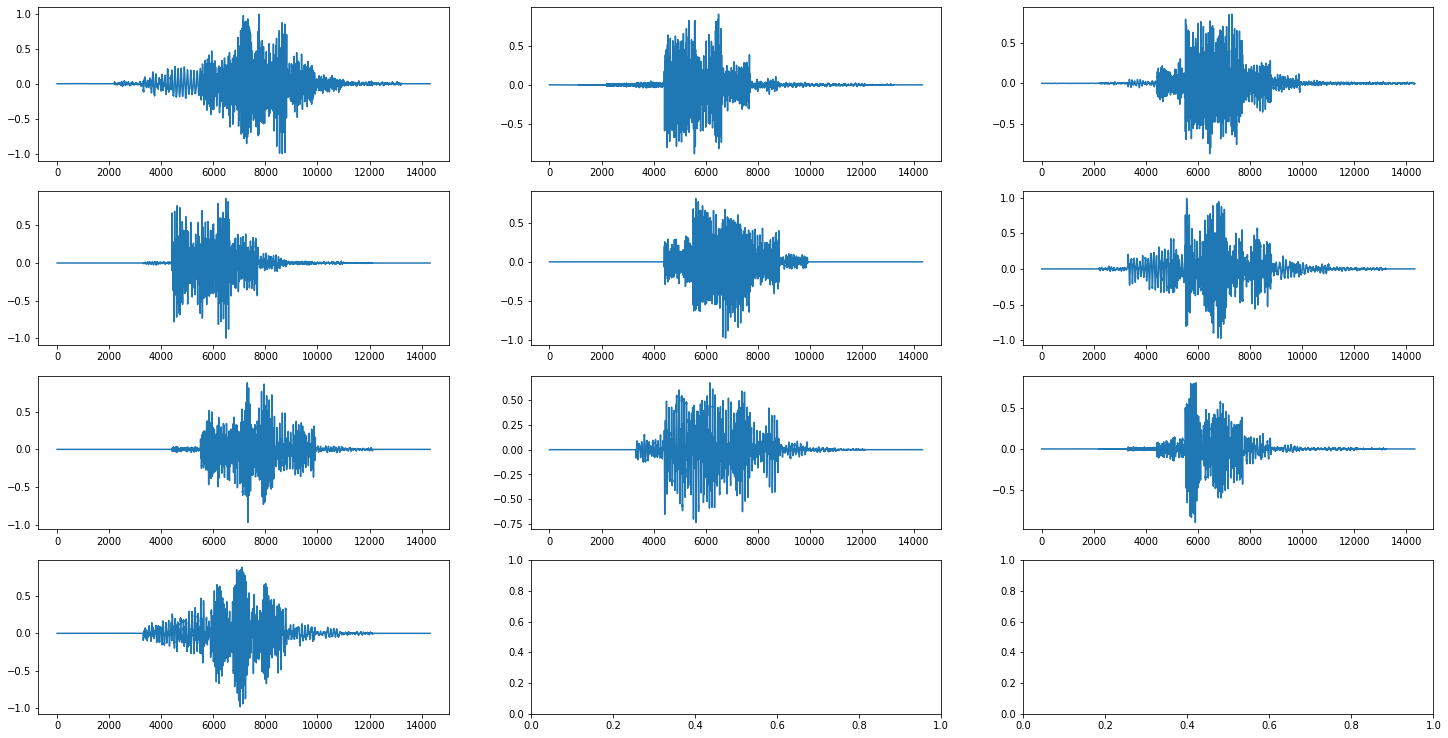

In [184]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(cutSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### Analysis

#### Plotting windows for 1st syllable

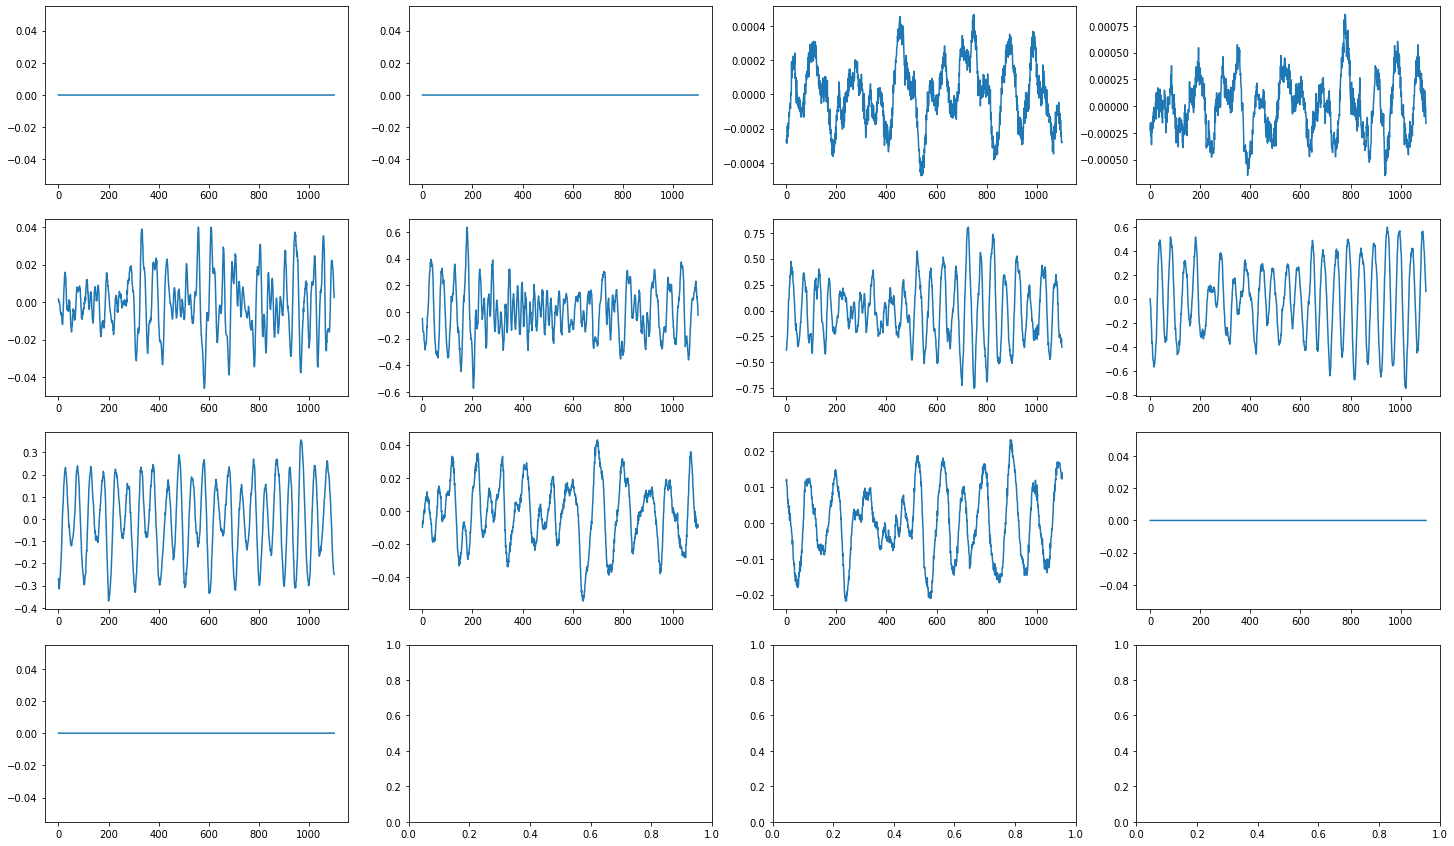

In [110]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

#### Shutting off first and last 20 samples

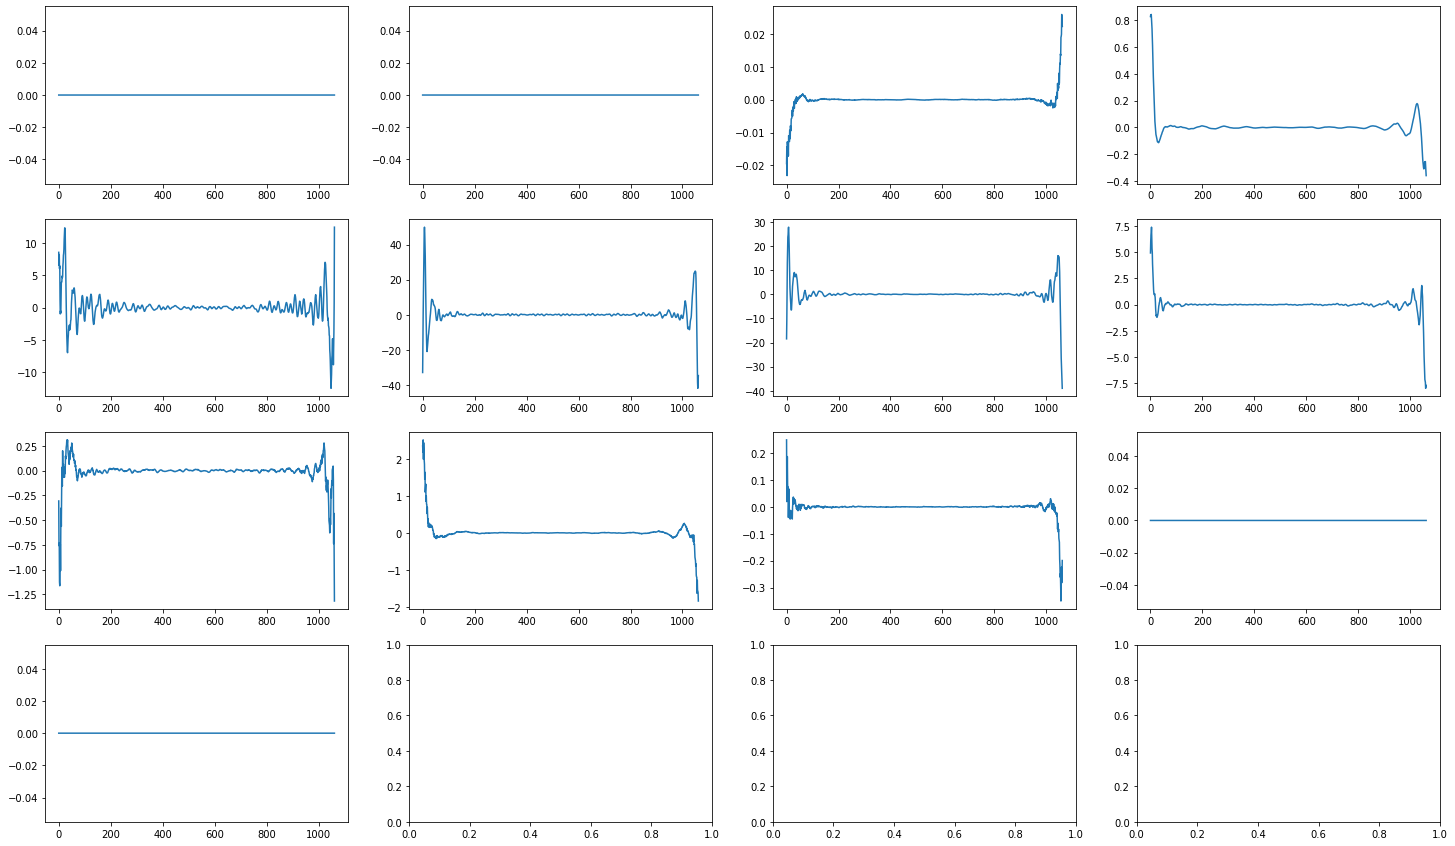

In [37]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j][20:-20])
        if 4 * i + j == 12:
            break

In [40]:
# Saving...

save = np.empty(0)
for i in range(4):
    for j in range(4):
        save = np.append(save, Signal[4 * i + j][20:-20], axis=0)
        if 4 * i + j == 12:
            break

scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, save)
# Result: bad quality as expected

In [96]:
x = cutSignal[0][(cutSignal[0] > 0.05) | (cutSignal[0] < -0.05)]
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)
x.shape

(3039,)

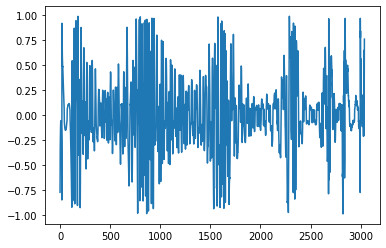

In [97]:
plt.plot(x)

# 50 ms row -> 10 frames

In [6]:
FRAME_SIZE = 346
SR = 22050
HOP_LENGTH = 84

In [5]:
FRAME_SIZE = 512
SR = 22050
HOP_LENGTH = 118

In [6]:
Snd.shape

(10, 13, 1102)

In [12]:
Specs = np.empty((0, 257*6))
for syl in Snd:
    for row in syl:
        x = np.abs(librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False)).reshape(1, -1)
        Specs = np.append(Specs, x, axis=0)
Specs = np.append(Specs, np.zeros((2, 257*6)), axis=0)
Specs.shape

(152, 1542)

In [121]:
Specs = np.concatenate((Specs[-1].reshape(1, 13, 1542), Specs[:-1]), axis=0)

In [10]:
Signal = np.empty((0, 1102))
for spec in Specs.reshape(-1, 1542):
    x_ = restore(spec.reshape(257, 6), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x)

In [13]:
Specs = Specs.reshape(1, -1).reshape(257, -1)

In [15]:
x_ = restore(Specs, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x_)

### 10 syllable plots

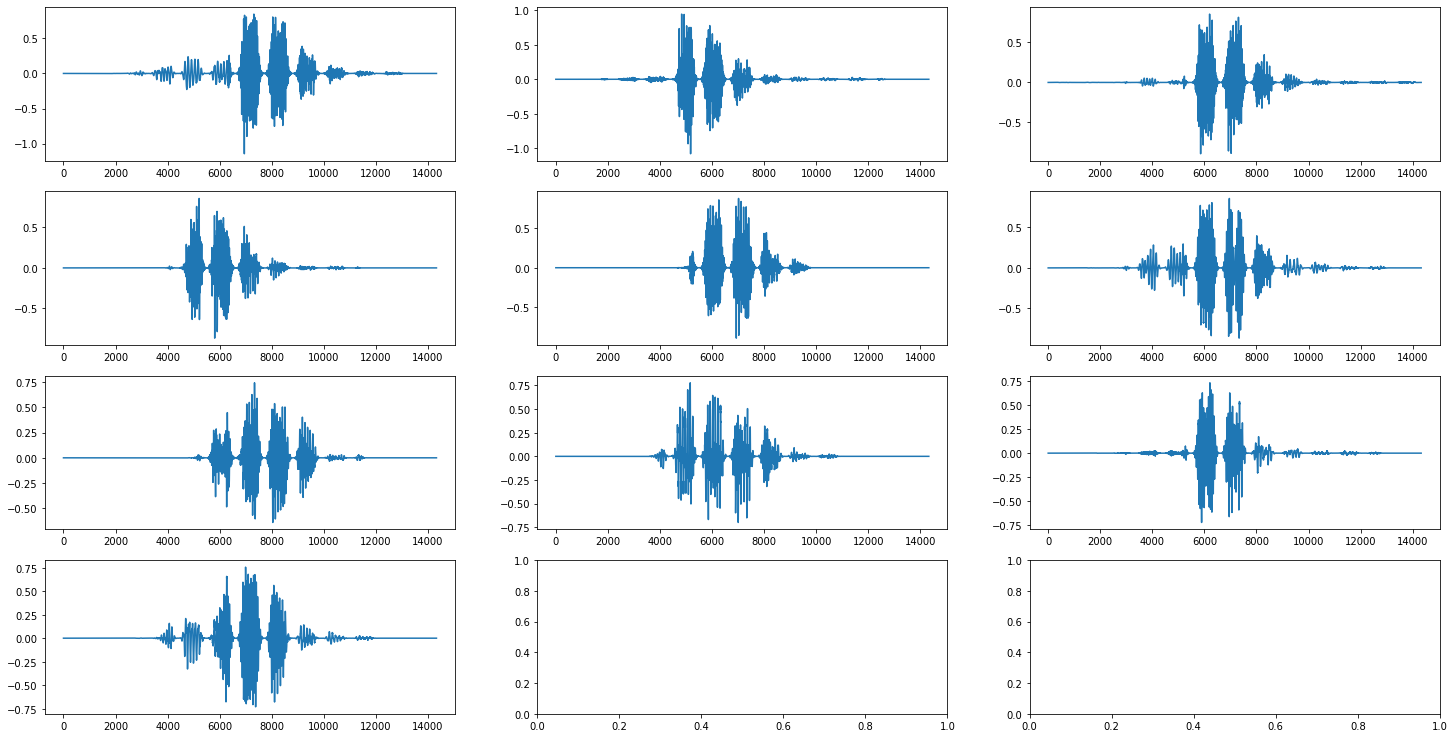

In [124]:
pltSignal = Signal.reshape(10, -1)
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(pltSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### 1st syllable (all 13 rows)

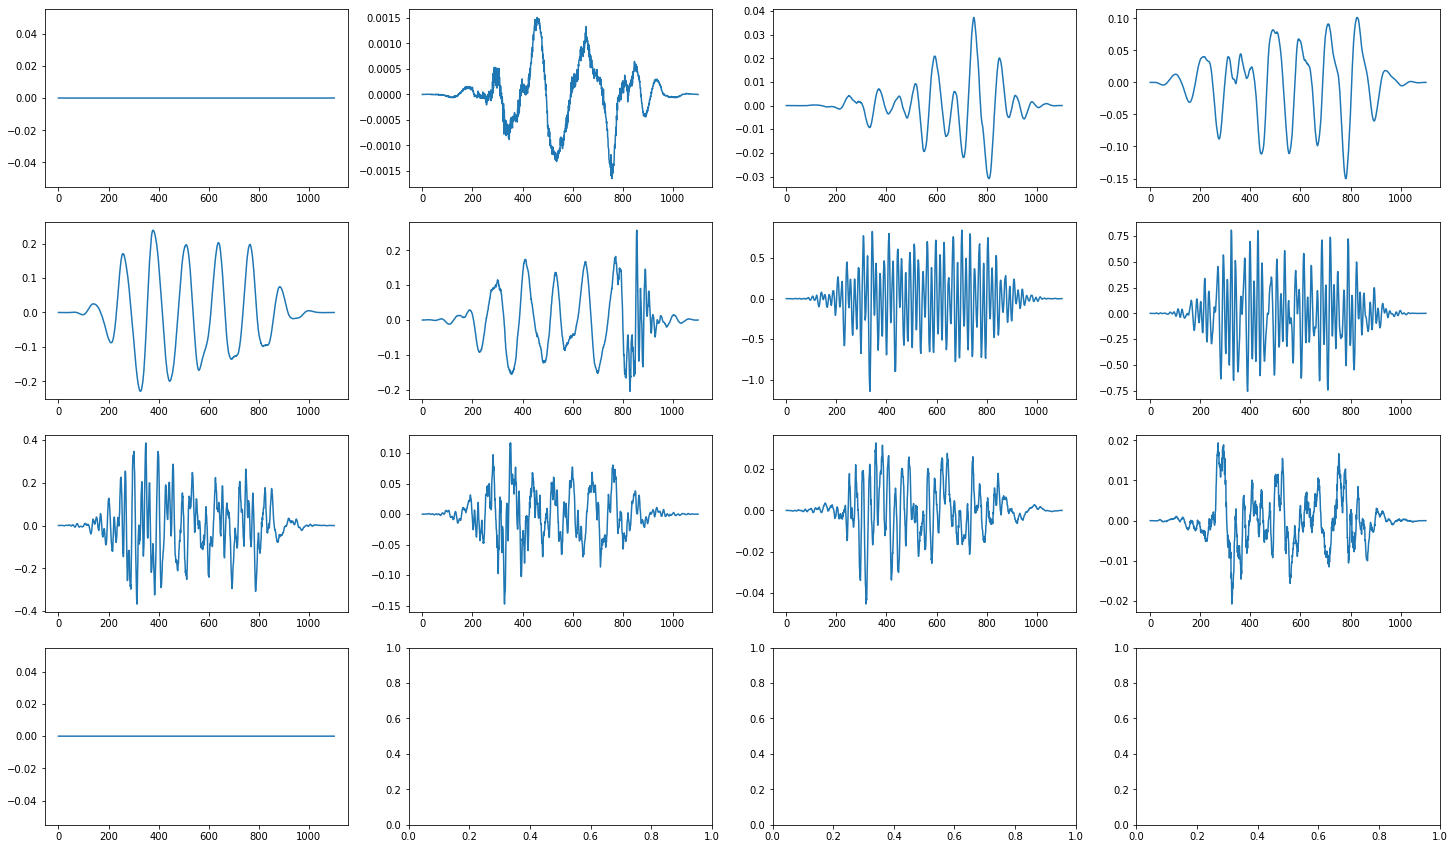

In [125]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

In [136]:
### Saving filtered file

save = np.empty(0)
for i in range(130):
    save = np.append(save, Signal[i][110:-110], axis=0)
    
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/cut.wav', SR, save)

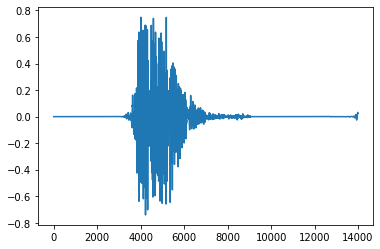

In [137]:
plt.plot(save[:14000])

# Tests..

In [2]:
A = np.loadtxt('columns.csv', delimiter=';', ndmin=2)

In [8]:
B = np.loadtxt('data.csv', delimiter=';', ndmin=2)

In [9]:
B.shape

(25586, 1176)

In [10]:
np.savetxt("/home/srg/Documents/MSU/EEG/data/50ms/bash.csv", np.concatenate((A, B), axis=1), delimiter=",")